In [1]:
import tensorflow as tf

In [26]:
import numpy as np
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Embedding, Reshape, Activation, Input, Lambda, Dense
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import gensim

In [16]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer # takes into consideration the morphological analysis of the words
from nltk.stem.porter import PorterStemmer # cutting off the end or the beginning of the word.

In [4]:
remove_terms = punctuation + '0123456789'

In [5]:
def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in remove_terms]
    # stopw = stopwords.words('english')
    # tokens = [token for token in tokens if token not in stopw]
    # remove words less than three letters
    # token = [word for word in tokens if len(word) >= 3]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #lemmanize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

## Downloading Book

In [6]:
path = get_file('cosmos.txt',origin='http://gutenberg.org/files/8172/8172-0.txt')
# or 
# corpus = open('historyOfAstronomy.txt',encoding='utf8').readlines()

In [7]:
corpus = open('historyOfAstronomy.txt',encoding='utf8').readlines()

In [8]:
corpus = [preprocessing(t) for t in corpus if t.strip() != '']

In [17]:
corpus[:10]

['The Project Gutenberg EBook of History of Astronomy by George Forbes',
 'This eBook is for the use of anyone anywhere in the United States and most',
 'other part of the world at no cost and with almost no restriction',
 'whatsoever You may copy it give it away or it under the term of',
 'the Project Gutenberg License included with this eBook or online at',
 'If you are not located in the United States you have',
 'to check the law of the country where you are located before using this ebook',
 'Title History of Astronomy',
 'Author George Forbes',
 'Release Date June EBook']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [10]:
X_train_tokens = tokenizer.texts_to_sequences(corpus)

In [20]:
word2id = tokenizer.word_index
id2word = dict([(value, key) for (key, value) in word2id.items()])

In [21]:
vocab_size = len(word2id) + 1
vocab_size

4723

In [13]:
items = tokenizer.word_index.items()

In [14]:
items

dict_items([('the', 1), ('of', 2), ('and', 3), ('a', 4), ('to', 5), ('in', 6), ('that', 7), ('by', 8), ('it', 9), ('wa', 10), ('is', 11), ('he', 12), ('s', 13), ('be', 14), ('with', 15), ('this', 16), ('for', 17), ('his', 18), ('at', 19), ('on', 20), ('which', 21), ('from', 22), ('star', 23), ('been', 24), ('or', 25), ('have', 26), ('not', 27), ('but', 28), ('sun', 29), ('these', 30), ('ha', 31), ('all', 32), ('an', 33), ('motion', 34), ('are', 35), ('work', 36), ('observation', 37), ('were', 38), ('earth', 39), ('planet', 40), ('one', 41), ('had', 42), ('found', 43), ('year', 44), ('great', 45), ('time', 46), ('moon', 47), ('their', 48), ('so', 49), ('line', 50), ('project', 51), ('orbit', 52), ('law', 53), ('when', 54), ('made', 55), ('we', 56), ('no', 57), ('about', 58), ('other', 59), ('theory', 60), ('solar', 61), ('same', 62), ('any', 63), ('also', 64), ('first', 65), ('astronomy', 66), ('you', 67), ('comet', 68), ('new', 69), ('discovery', 70), ('there', 71), ('if', 72), ('more'

# Creating Word2Vec Model

In [22]:
embed_size = 300
window_size = 2

In [30]:
from keras.preprocessing.sequence import pad_sequences

def generate_context_word_pairs(corpus, window_size, vocab_size):
    
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index])
            
            label_word.append(word)
            
            x = pad_sequences(context_words, maxlen= context_length) # normlizing the length of the vectors.
            y = to_categorical(label_word, vocab_size) # transforming the words into numbers.
            
            yield (x,y)

visualizing function

In [31]:
i = 0
for x,y in generate_context_word_pairs(X_train_tokens, window_size, vocab_size):
    
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y)', id2word[np.argwhere(y[0])[0][0]])
        
        if i == 10:
            break
        i += 1

Context (X): ['the', 'project', 'ebook', 'of'] -> Target (Y) gutenberg
Context (X): ['project', 'gutenberg', 'of', 'history'] -> Target (Y) ebook
Context (X): ['gutenberg', 'ebook', 'history', 'of'] -> Target (Y) of
Context (X): ['ebook', 'of', 'of', 'astronomy'] -> Target (Y) history
Context (X): ['of', 'history', 'astronomy', 'by'] -> Target (Y) of
Context (X): ['history', 'of', 'by', 'george'] -> Target (Y) astronomy
Context (X): ['of', 'astronomy', 'george', 'forbes'] -> Target (Y) by
Context (X): ['this', 'ebook', 'for', 'the'] -> Target (Y) is
Context (X): ['ebook', 'is', 'the', 'use'] -> Target (Y) for
Context (X): ['is', 'for', 'use', 'of'] -> Target (Y) the
Context (X): ['for', 'the', 'of', 'anyone'] -> Target (Y) use


In [37]:
corpus[:10]

['The Project Gutenberg EBook of History of Astronomy by George Forbes',
 'This eBook is for the use of anyone anywhere in the United States and most',
 'other part of the world at no cost and with almost no restriction',
 'whatsoever You may copy it give it away or it under the term of',
 'the Project Gutenberg License included with this eBook or online at',
 'If you are not located in the United States you have',
 'to check the law of the country where you are located before using this ebook',
 'Title History of Astronomy',
 'Author George Forbes',
 'Release Date June EBook']

end of visualizing fuction

# Creating Model

In [42]:
model = Sequential()

In [43]:
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embed_size,
                    embeddings_initializer='glorot_uniform',
                    input_length=window_size*2
                   ))

In [47]:
# because we are looking for a target word in the center then we need to calculate the average of the context vectors.
model.add(Lambda(lambda x: tf.python.keras.backend.mean(x, axis=1), output_shape=(embed_size,))) 

In [48]:
model.add(Dense(vocab_size, kernel_initializer='glorot_uniform', activation='softmax'))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 300)            1416900   
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 4723)              1421623   
Total params: 2,838,523
Trainable params: 2,838,523
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [51]:
n_epochs = 15
for epoch in range(n_epochs):
    loss = 0
    for x, y in generate_context_word_pairs(X_train_tokens, window_size, vocab_size):
        loss += model.train_on_batch(x,y)
        
    print('Epoch', epoch, '\tloss', loss)

Epoch 0 	loss 295388.7927538045
Epoch 1 	loss 261205.73955110274
Epoch 2 	loss 229322.6844545477
Epoch 3 	loss 198479.20716457983
Epoch 4 	loss 172238.7180129703
Epoch 5 	loss 151595.14424299114
Epoch 6 	loss 136128.78833482962
Epoch 7 	loss 124590.12445292331
Epoch 8 	loss 115903.76373084629
Epoch 9 	loss 109519.23659383458
Epoch 10 	loss 104986.99080829274
Epoch 11 	loss 101757.71843544429
Epoch 12 	loss 99552.38754415442
Epoch 13 	loss 98141.35915660349
Epoch 14 	loss 97218.5044450842


Modelo não se saiu bem, erro está alto, isso se deve pois o corpus de treinamento é muito pequeno para que se consiga bons resultados.

# Word Embeddings Vectors

In [54]:
import pandas as pd

In [52]:
weights = model.get_weights()[0]
weights = weights[1:]
weights.shape

(4722, 300)

In [55]:
pd.DataFrame(weights, index=list(id2word.values())).head(50)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.288683,-1.332486,-0.147406,-1.523885,0.077305,0.249184,-0.050268,0.131297,-0.179183,-0.860467,...,0.748856,0.162708,0.580595,0.407831,0.959554,0.395771,-0.446277,-0.330092,-0.155912,-0.443106
of,0.479635,-1.272258,-0.525597,-1.404226,-0.126523,-0.305790,0.212362,-0.016532,0.095639,-0.328102,...,-0.390439,-0.048962,-0.980272,-0.026328,0.200277,0.824208,-0.522959,0.157480,-0.182175,-0.104529
and,-0.307849,1.032569,-1.223003,0.327619,0.403014,-0.932039,-0.634729,0.054653,0.380322,-0.415784,...,-0.247437,0.746664,-0.704137,0.667039,0.070050,1.441075,-0.208117,0.484817,-0.080280,-0.118461
a,0.637326,-0.735631,-0.504735,-0.143543,-0.170155,0.027174,-0.822258,-0.283743,-0.602546,-0.414006,...,2.306487,-0.048796,0.170580,0.646462,0.616994,0.590993,-0.237318,-0.630857,0.013034,-0.463910
to,0.009204,-1.936935,-0.714222,0.057875,0.391344,-0.727373,0.235959,-0.217258,-0.290700,-0.828264,...,1.413146,0.648925,-0.082339,-0.028508,0.372102,0.898629,-0.493978,-0.136611,-0.324779,-0.247911
in,-0.526718,-1.024843,-0.238648,0.166208,0.490311,-0.793396,-0.007671,-0.767124,1.917833,-0.352998,...,-0.408831,0.158119,-0.591946,-0.368910,0.996818,1.132180,-1.258485,-0.222173,0.133233,-0.350923
that,0.215307,-0.672905,0.295622,-0.816918,0.250005,0.404581,0.014339,0.130242,-0.542004,-0.411330,...,-0.388991,0.365311,0.485073,0.389752,0.968048,-0.549901,-0.514635,1.045704,-0.206415,-0.001346
by,1.038562,-0.703441,-0.185212,-0.321402,0.305112,0.235969,0.204675,0.433557,-0.750643,-0.119846,...,-0.257857,-0.097524,-0.382789,-0.709037,0.295249,0.011015,-0.100135,-0.235509,0.025111,0.251724
it,-0.105267,-0.349853,0.048375,-0.052222,-0.619380,-0.812844,-0.667564,0.188595,-0.490544,-0.324617,...,-0.184348,0.264178,0.096430,1.125306,-0.559768,0.736019,-0.215457,-0.744776,-0.586882,0.689235
wa,1.088755,-0.604408,0.383580,0.354803,1.299955,0.750194,0.278065,0.647776,0.115623,-0.030140,...,0.020144,-0.726924,-0.006434,0.765974,-1.095004,0.379166,0.197009,-0.680788,0.147473,0.135226


# Similar words

In [57]:
distance_matrix = cosine_similarity(weights)
print(distance_matrix.shape)

(4722, 4722)


In [58]:
similar_words = {search_term :[id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] for search_term in ['copernicus','system', 'sun', 'halley', 'kepler','discovery', 'ancient']}
similar_words

{'copernicus': ['discrete', 'medici', 'stand', 'hath', 'avoiding'],
 'system': ['coming', 'acad', 'meditating', 'dollond', 'bd'],
 'sun': ['fitted', 'roubiliac', 'mem', 'accompanied', 'handed'],
 'halley': ['gbnewby', 'accustomed', 'affirmed', 'nicolai', 'arabic'],
 'kepler': ['unreduced', 'won', 'handbook', 'rendered', 'pious'],
 'discovery': ['persian', 'occupy', 'lagrange', 'recalculated', 'approaching'],
 'ancient': ['anaxagoras', 'seventy', 'impressive', 'california', 'definite']}

Visualizing words relationships

pego similar_words e ploto em 2D:

In [59]:
words = sum([[k]+v for k, v in similar_words.items()],[])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding Shapes:',word_vectors.shape)

Total words: 42 	Word Embedding Shapes: (42, 300)


In [63]:
tsne = TSNE(n_components=2, random_state=2018, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

In [65]:
import matplotlib.pyplot as plt

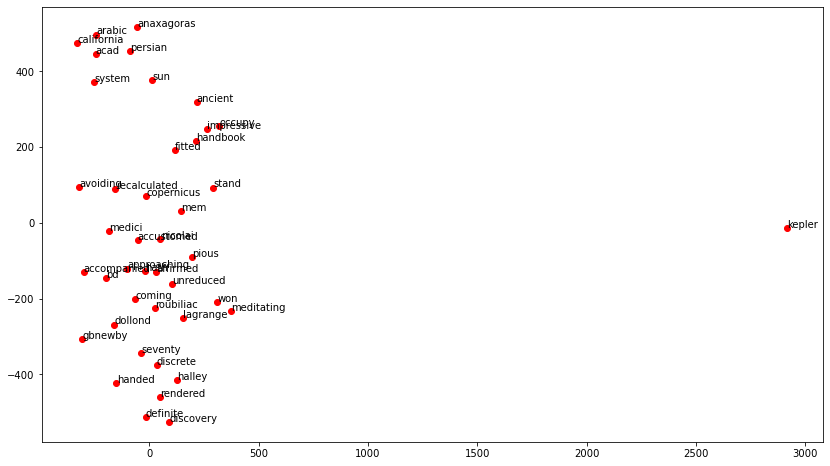

In [66]:
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='red')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')